### 20190608 flow data

In [1]:
import fcsparser

import pandas as pd
import math
import os
#import all data, and merge into a single datatframe, with sample names in extra columns


def log_trans(x):
    try:
        return math.log(x, 10)
    except:
        return float('NaN')

data_folder = 'flowjo_gating'

#collect guide names from plate layout data
layout_file = open('20190607_flow_transfection_layout.txt')
guide_numbers = []
sample_dict = {}
guides = []
genes = []
for line in layout_file.readlines():
    number, gene, guide_num = line.strip().split('\t')[:3]
    sample_dict[int(number)] = [gene, guide_num]
    guides.append(gene + '_' + guide_num)
    genes.append(gene)
layout_file.close()

#will only look at data gated on good scatter
cell_lines = ['cBZ056', 'cBZ058']
stop_codons = ['UGAC', 'AQP4']
conditions = ['DMSO', 'SMG1i']
dfs = []
stop_codon_index = 0
sample_index = 1
for cell_line in cell_lines:
    guide_index=0
    for condition in conditions:
        for NA in range(len(guides)):
            data_file_name = 'export_%s_tdTomato_tagBFP_%03d_%03d_FSC_single.fcs' % (cell_line, guide_index+1, sample_index)
            data_file_path = os.path.join(data_folder, data_file_name)
            meta, data = fcsparser.parse(data_file_path, meta_data_only=False, reformat_meta=True)
            data['gene'] = sample_dict[guide_index%(len(guides))+1][0]
            guide = '%s_%s' % (sample_dict[guide_index%(len(guides))+1][0], sample_dict[guide_index%(len(guides))+1][1])
            data['guide'] = guide
            data['guide number'] = sample_dict[guide_index%(len(guides))+1][1]
            data['cell line'] = cell_line
            data['stop codon'] = stop_codons[stop_codon_index]
            data['condition'] = condition
            data['sample'] = '%s_%s_%s' % (stop_codons[stop_codon_index], guide, condition)
            dfs.append(data.sample(n=5000)) 
            #dfs.append(data) #to subsample and speed up plotting, use the above line instead of this one
            sample_index+=1
            guide_index+=1
    stop_codon_index += 1
all_data = pd.concat(dfs)
all_data = all_data.rename(index=str, columns={'PE-A':'tdTomato-A', 'Pacific Blue-A':'tagBFP-A'})
all_data['tdTomato/tagBFP'] = all_data['tdTomato-A']/all_data['tagBFP-A']
all_data['log tdTomato'] = all_data['tdTomato-A'].apply(log_trans)
all_data['log tagBFP'] = all_data['tagBFP-A'].apply(log_trans)
all_data['log tdTomato/tagBFP'] = all_data['tdTomato/tagBFP'].apply(log_trans)

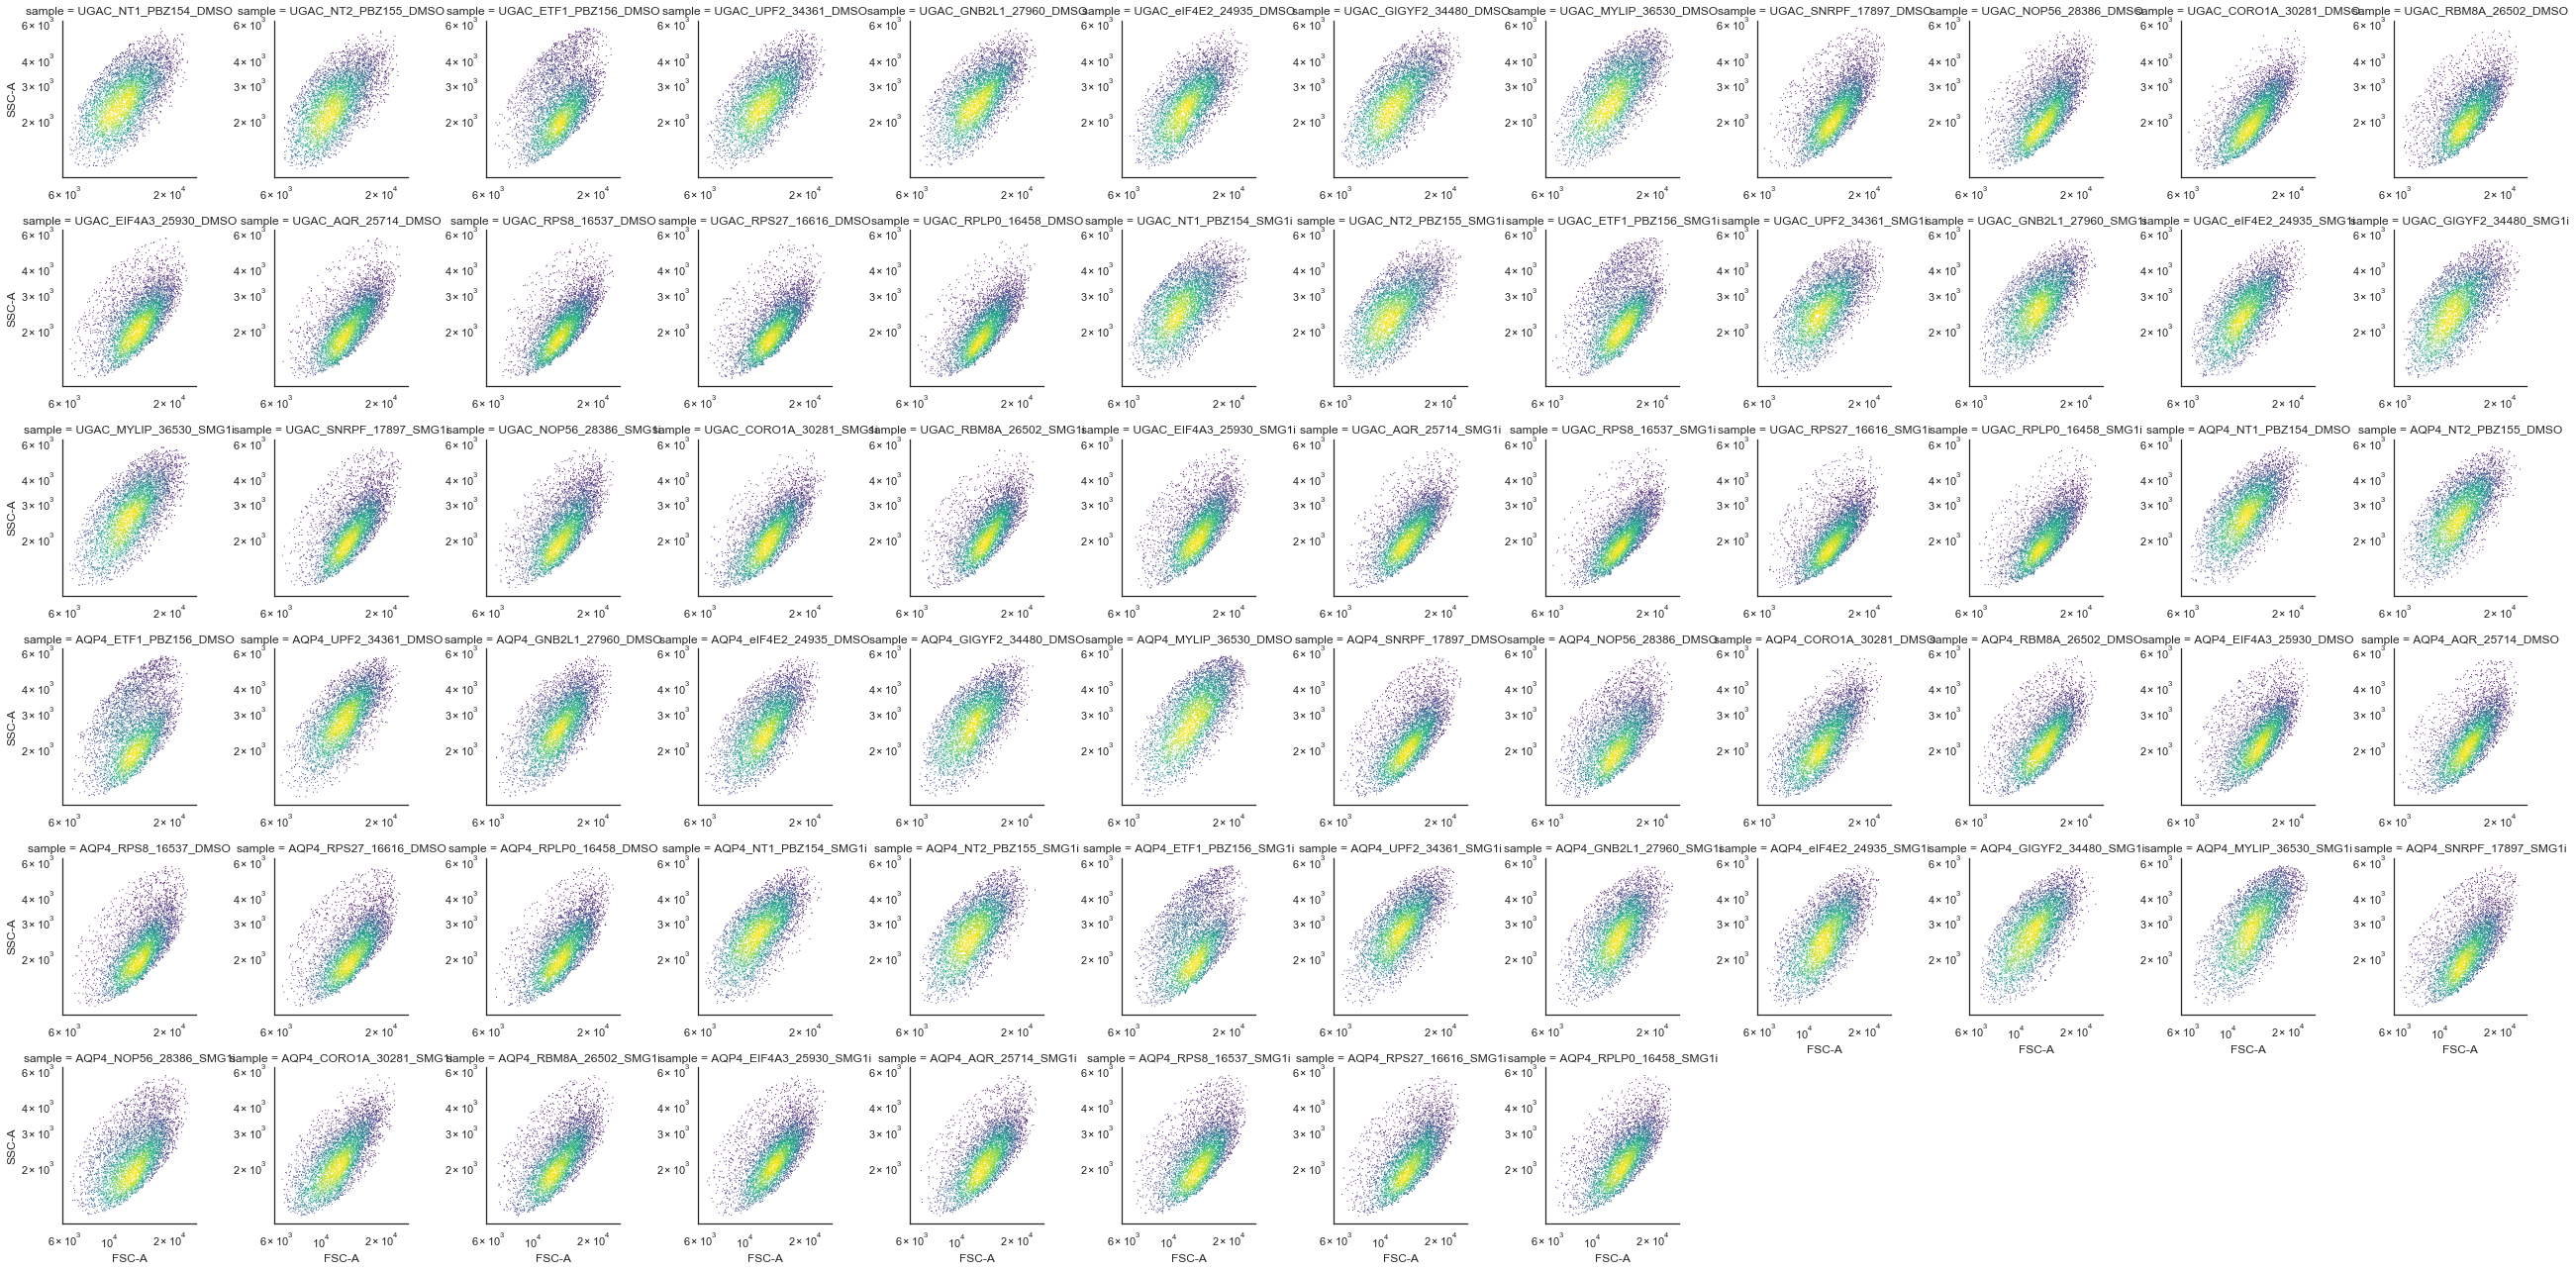

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['pdf.fonttype'] = 42 #leaves most text as actual text in PDFs, not outlines
import seaborn as sns
from scipy.stats import gaussian_kde
import numpy as np
sns.set(style="white", color_codes=True)
def density_colored_scatter(x, y, color, **kwargs):
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    plt.scatter(x, y, c=z, **kwargs)
    plt.yscale('log')
    plt.xscale('log')
    #cutoff = 400
    #pos = [xval for xval in x if xval>=cutoff]
    #percent_pos = 100.*len(pos)/len(x)
    #plt.vlines(cutoff,1,1000000, linestyle='dashed')
    #plt.annotate("%.1f" % percent_pos, xy=(cutoff+1, 500000))
    
#xlim=(1,1000000),ylim=(1,1000000)
g = sns.FacetGrid(all_data, col="sample", col_wrap=12)

cmap = 'viridis'
g= g.map(density_colored_scatter, "FSC-A", "SSC-A", cmap=cmap, s=1, linewidth=0)
plt.savefig('20190608_FSC_SSC_A.pdf', transparent=True)
plt.savefig('20190608_FSC_SSC_A.png', transparent=True)

In [3]:
grouped_data = all_data.groupby(['stop codon', 'gene', 'condition'])

In [4]:
#colors - colorblind safe
black = (0,0,0)
gray = (0.6,0.6,0.6)
orange = (230/255.0,159/255.0,0)
skyBlue = (86/255.0,180/255.0,233/255.0)
bluishGreen = (0,158/255.0,115/255.0)
yellow = (240/255.0,228/255.0,66/255.0)
blue = (0,114/255.0,178/255.0)
vermillion = (213/255.0,94/255.0,0)
reddishPurple = (204/255.0,121/255.0,167/255.0)
colors = [black, vermillion, orange, skyBlue, bluishGreen, blue, reddishPurple, yellow, gray]

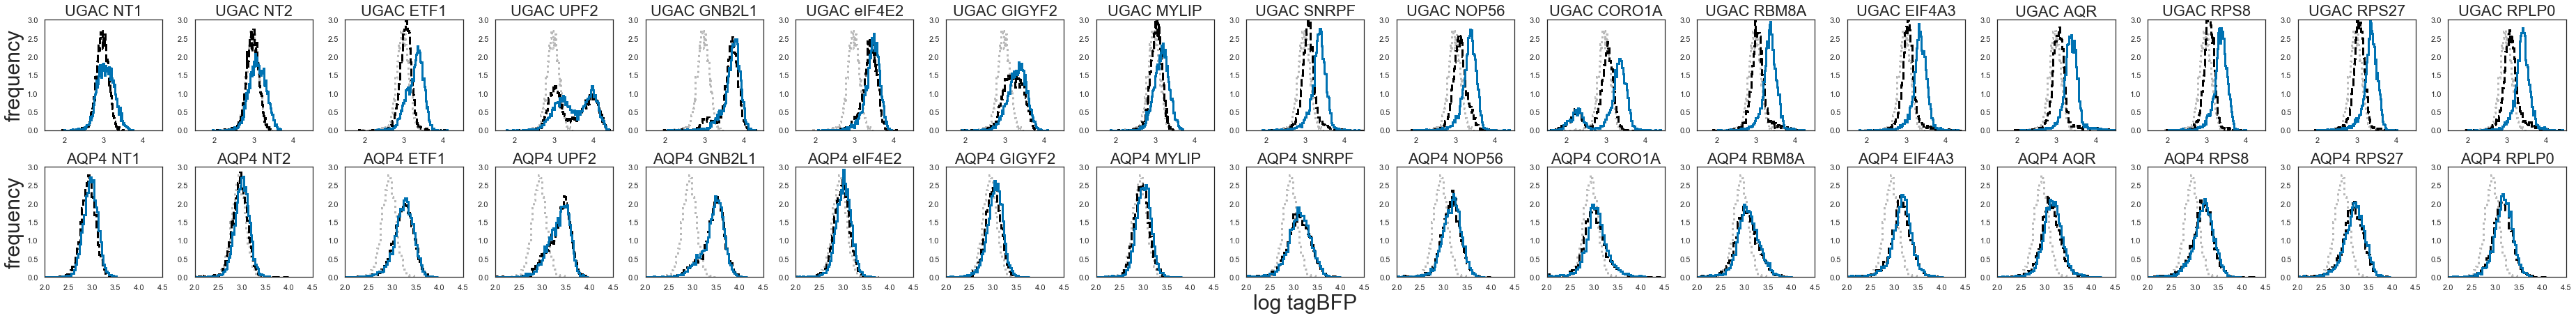

In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42 #leaves most text as actual text in PDFs, not outlines

import scipy.stats as stats
import numpy as np

#xmin=0
#xmax=100
#ymin=-0.1
#ymax=4
plots=[]
num_plots_wide = 17
num_plots_high = 2

x_var='log tagBFP'
#y_var='tdTomato-A'
plot_index =1
fig = plt.figure(figsize=(3*num_plots_wide, 3*num_plots_high))
for stop_codon in stop_codons:
    for gene in genes:
        plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
        plots.append(plot)
        condition_index = 0
        NT1_data = grouped_data.get_group((stop_codon, 'NT1', 'DMSO'))
        DMSO_data = grouped_data.get_group((stop_codon, gene, 'DMSO'))
        SMG1i_data = grouped_data.get_group((stop_codon, gene, 'SMG1i'))
        NT1_data[x_var].plot.hist(histtype='step', bins=100, normed=True, color=gray, ls='dotted', alpha=0.7, ax=plot, lw=3)
        DMSO_data[x_var].plot.hist(histtype='step', bins=100, normed=True, color=black, ls='--', alpha=1, ax=plot, lw=3)
        SMG1i_data[x_var].plot.hist(histtype='step', bins=100, normed=True, color=blue, alpha=1, ax=plot, lw=3)
        plot.set_title('%s %s'% (stop_codon, gene), fontsize=22)
        plot.set_xlabel('', fontsize=1)
        plot.set_ylabel('', fontsize=1)
        #plot.set_ylabel(y_var)
        #lot.set_xlim(xmin, xmax)
        plot.set_ylim(0, 3)
        if stop_codon == 'UGAC':
            plot.set_xlim(1.5, 4.5)
        elif stop_codon == 'AQP4':
            plot.set_xlim(2, 4.5)
        elif stop_codon == 'UGGC':
            plot.set_xlim(2, 3.5)
        guide_index+=1
        plot_index += 1
plt.tight_layout()
plots[25].set_xlabel(x_var, fontsize=30)
plots[0].set_ylabel('frequency', fontsize=30)
plots[17].set_ylabel('frequency', fontsize=30)

plt.savefig('20190608_log_tagBFP_hist_dmso_vs_smg1i.pdf', transparent=True)

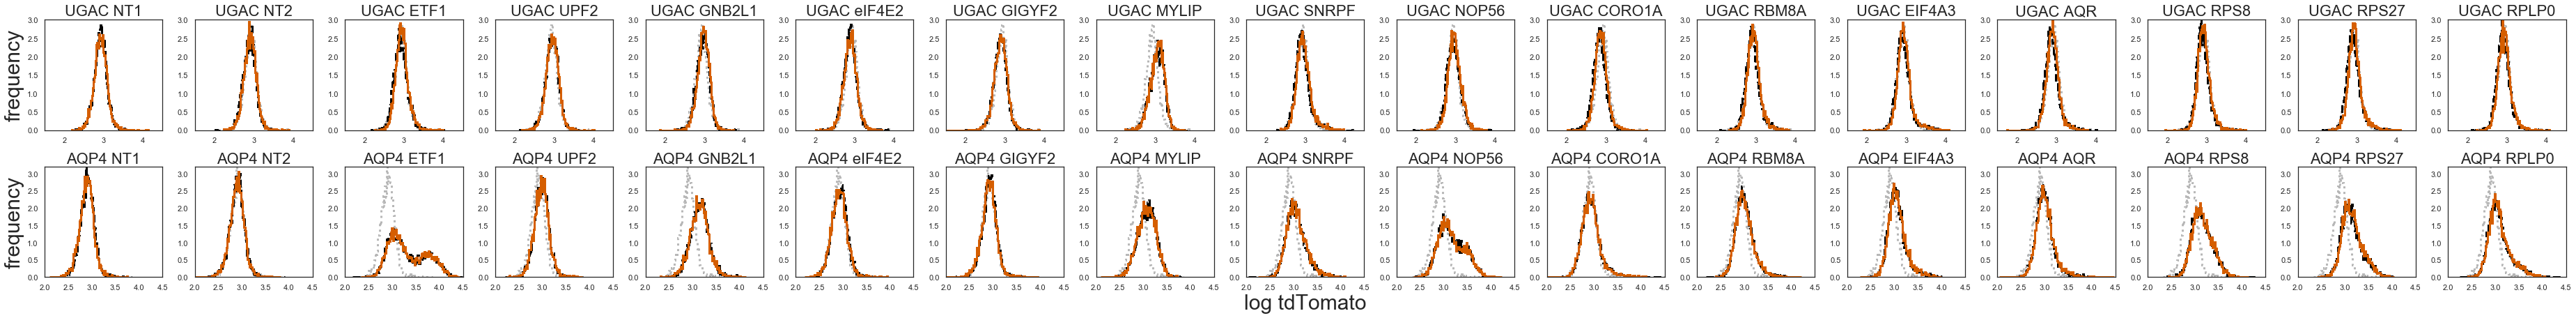

In [6]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

#xmin=0
#xmax=100
#ymin=-0.1
#ymax=4
plots=[]
num_plots_wide = 17
num_plots_high = 2

x_var='log tdTomato'
#y_var='tdTomato-A'
plot_index =1
fig = plt.figure(figsize=(3*num_plots_wide, 3*num_plots_high))
for stop_codon in stop_codons:
    for gene in genes:
        plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
        plots.append(plot)
        condition_index = 0
        NT1_data = grouped_data.get_group((stop_codon, 'NT1', 'DMSO'))
        DMSO_data = grouped_data.get_group((stop_codon, gene, 'DMSO'))
        SMG1i_data = grouped_data.get_group((stop_codon, gene, 'SMG1i'))
        NT1_data[x_var].plot.hist(histtype='step', bins=100, normed=True, color=gray, ls='dotted', alpha=0.7, ax=plot, lw=3)
        DMSO_data[x_var].plot.hist(histtype='step', bins=100, normed=True, color=black, ls='--', alpha=1, ax=plot, lw=3)
        SMG1i_data[x_var].plot.hist(histtype='step', bins=100, normed=True, color=vermillion, alpha=1, ax=plot, lw=3)
        plot.set_title('%s %s'% (stop_codon, gene), fontsize=22)
        plot.set_xlabel('', fontsize=1)
        plot.set_ylabel('', fontsize=1)
        #plot.set_ylabel(y_var)
        #lot.set_xlim(xmin, xmax)
        if stop_codon == 'UGAC':
            plot.set_xlim(1.5, 4.5)
            plot.set_ylim(0, 3)
        elif stop_codon == 'AQP4':
            plot.set_xlim(2, 4.5)
            plot.set_ylim(0, 3.2)
        elif stop_codon == 'UGGC':
            plot.set_xlim(2, 3.5)
        guide_index+=1
        plot_index += 1
plt.tight_layout()
plots[25].set_xlabel(x_var, fontsize=30)
plots[0].set_ylabel('frequency', fontsize=30)
plots[17].set_ylabel('frequency', fontsize=30)

plt.savefig('20190608_log_tdTomato_hist_dmso_vs_smg1i.pdf', transparent=True)

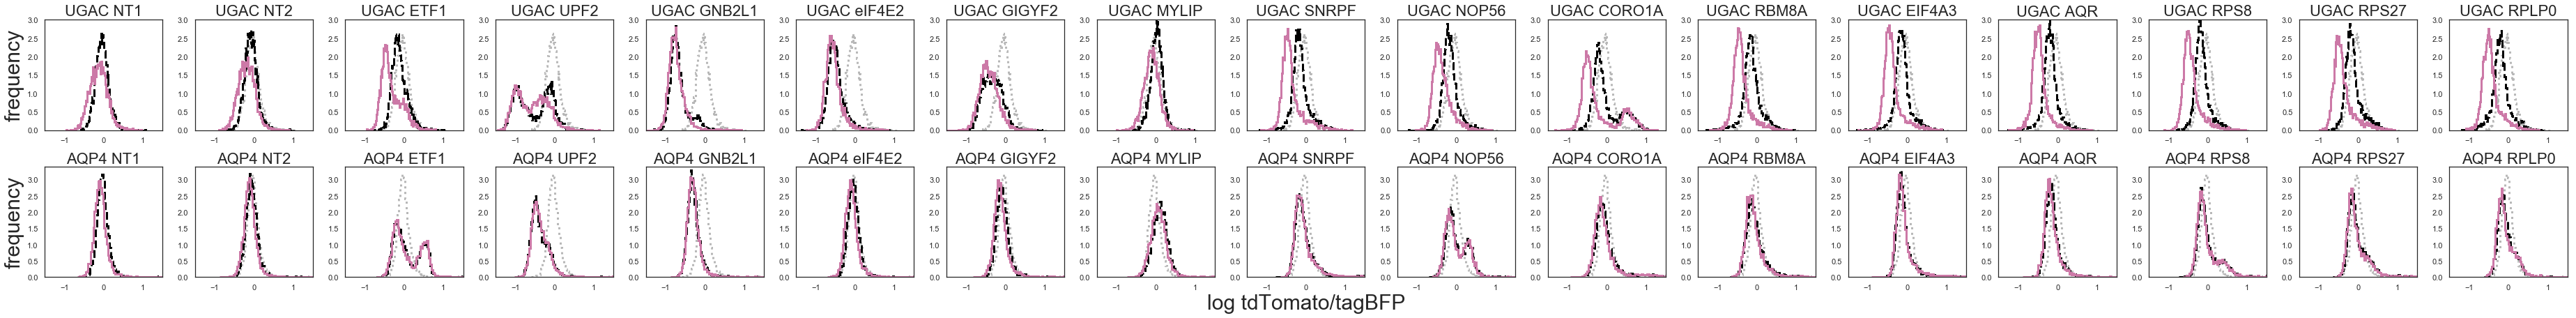

In [7]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

#xmin=0
#xmax=100
#ymin=-0.1
#ymax=4
plots=[]
num_plots_wide = 17
num_plots_high = 2

x_var='log tdTomato/tagBFP'
#y_var='tdTomato-A'
plot_index =1
fig = plt.figure(figsize=(3*num_plots_wide, 3*num_plots_high))
for stop_codon in stop_codons:
    for gene in genes:
        plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
        plots.append(plot)
        condition_index = 0
        NT1_data = grouped_data.get_group((stop_codon, 'NT1', 'DMSO')).replace([np.inf, -np.inf], np.nan).dropna()
        DMSO_data = grouped_data.get_group((stop_codon, gene, 'DMSO')).replace([np.inf, -np.inf], np.nan).dropna()
        SMG1i_data = grouped_data.get_group((stop_codon, gene, 'SMG1i')).replace([np.inf, -np.inf], np.nan).dropna()
        NT1_data[x_var].plot.hist(histtype='step', bins=100, normed=True, color=gray, ls='dotted', alpha=0.7, ax=plot, lw=3)
        DMSO_data[x_var].plot.hist(histtype='step', bins=100, normed=True, color=black, ls='--', alpha=1, ax=plot, lw=3)
        SMG1i_data[x_var].plot.hist(histtype='step', bins=100, normed=True, color=reddishPurple, alpha=1, ax=plot, lw=3)
        plot.set_title('%s %s'% (stop_codon, gene), fontsize=22)
        plot.set_xlabel('', fontsize=1)
        plot.set_ylabel('', fontsize=1)
        #plot.set_ylabel(y_var)
        #lot.set_xlim(xmin, xmax)
        
        if stop_codon == 'UGAC':
            plot.set_xlim(-1.5, 1.5)
            plot.set_ylim(0, 3)
        elif stop_codon == 'AQP4':
            plot.set_xlim(-1.5, 1.5 )
            plot.set_ylim(0, 3.4)
        elif stop_codon == 'UGGC':
            plot.set_xlim(2, 3.5)
        guide_index+=1
        plot_index += 1
plt.tight_layout()
plots[25].set_xlabel(x_var, fontsize=30)
plots[0].set_ylabel('frequency', fontsize=30)
plots[17].set_ylabel('frequency', fontsize=30)

plt.savefig('20190608_log_ratio_hist_dmso_vs_smg1i.pdf', transparent=True)

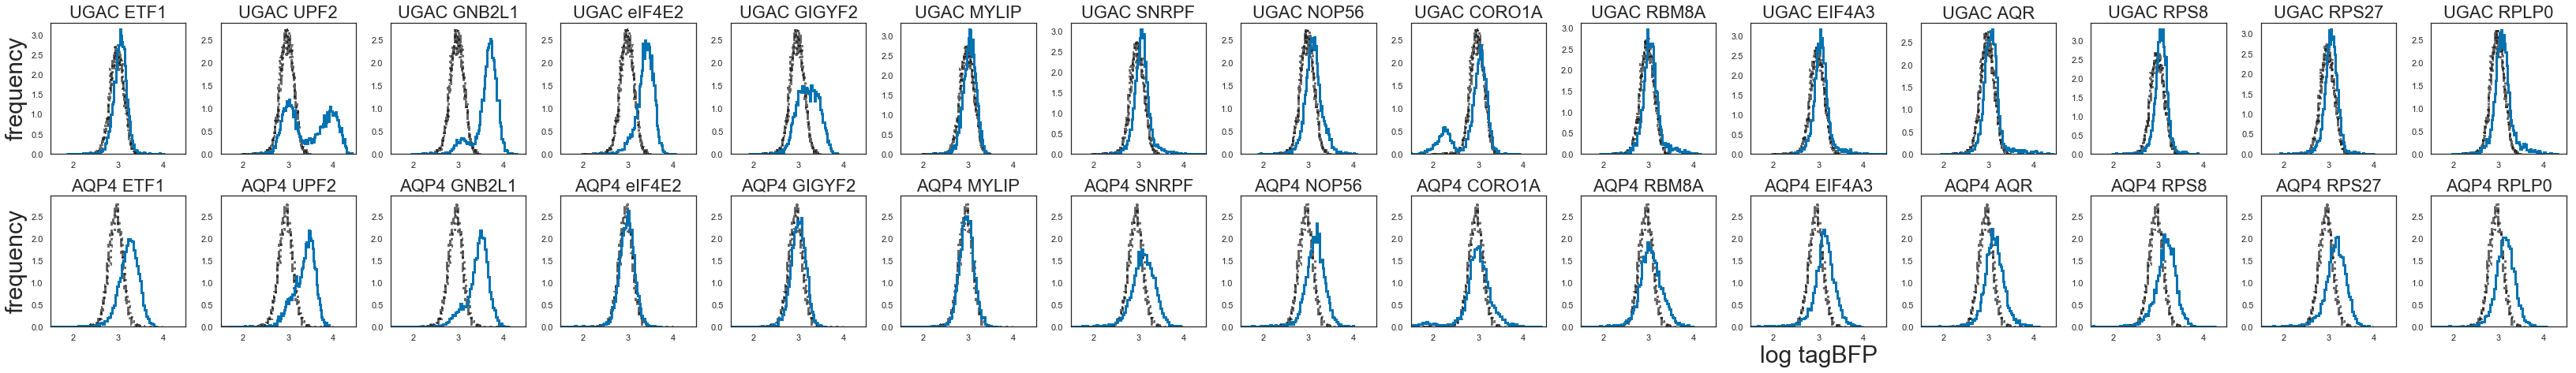

In [8]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

#xmin=0
#xmax=100
#ymin=-0.1
#ymax=4
plots=[]
num_plots_wide = 15
num_plots_high = 3

x_var='log tagBFP'
#y_var='tdTomato-A'
plot_index =1
fig = plt.figure(figsize=(3*num_plots_wide, 3*num_plots_high))
for stop_codon in stop_codons:
    for gene in genes[2:]:
        plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
        plots.append(plot)
        nt1_data = grouped_data.get_group((stop_codon, 'NT1', 'DMSO'))
        nt2_data = grouped_data.get_group((stop_codon, 'NT2', 'DMSO'))
        nt1_data[x_var].plot.hist(color=black, histtype='step', bins=100, normed=True, linestyle='--', alpha=0.6, ax=plot, lw=3)
        nt2_data[x_var].plot.hist(color=black, histtype='step', bins=100, normed=True, linestyle=':', alpha=0.6, ax=plot, lw=3)
        guide_data = grouped_data.get_group((stop_codon, gene, 'DMSO'))
        guide_data[x_var].plot.hist(histtype='step', bins=100, normed=True, color=blue, alpha=1, ax=plot, lw=3)
        plot.set_title('%s %s'% (stop_codon, gene), fontsize=22)
        plot.set_xlabel('', fontsize=1)
        plot.set_ylabel('', fontsize=1)
        #plot.set_ylabel(y_var)
        #lot.set_xlim(xmin, xmax)
        if stop_codon == 'UGAC':
            plot.set_xlim(1.5, 4.5)
        elif stop_codon == 'AQP4':
            plot.set_xlim(1.5, 4.5)
        elif stop_codon == 'UGGC':
            plot.set_xlim(2, 3.5)
        guide_index+=1
        plot_index += 1
plt.tight_layout()
plots[22].set_xlabel(x_var, fontsize=30)
plots[0].set_ylabel('frequency', fontsize=30)
plots[15].set_ylabel('frequency', fontsize=30)

plt.savefig('20190608_log_tagBFP_hist_DMSO.pdf', transparent=True)

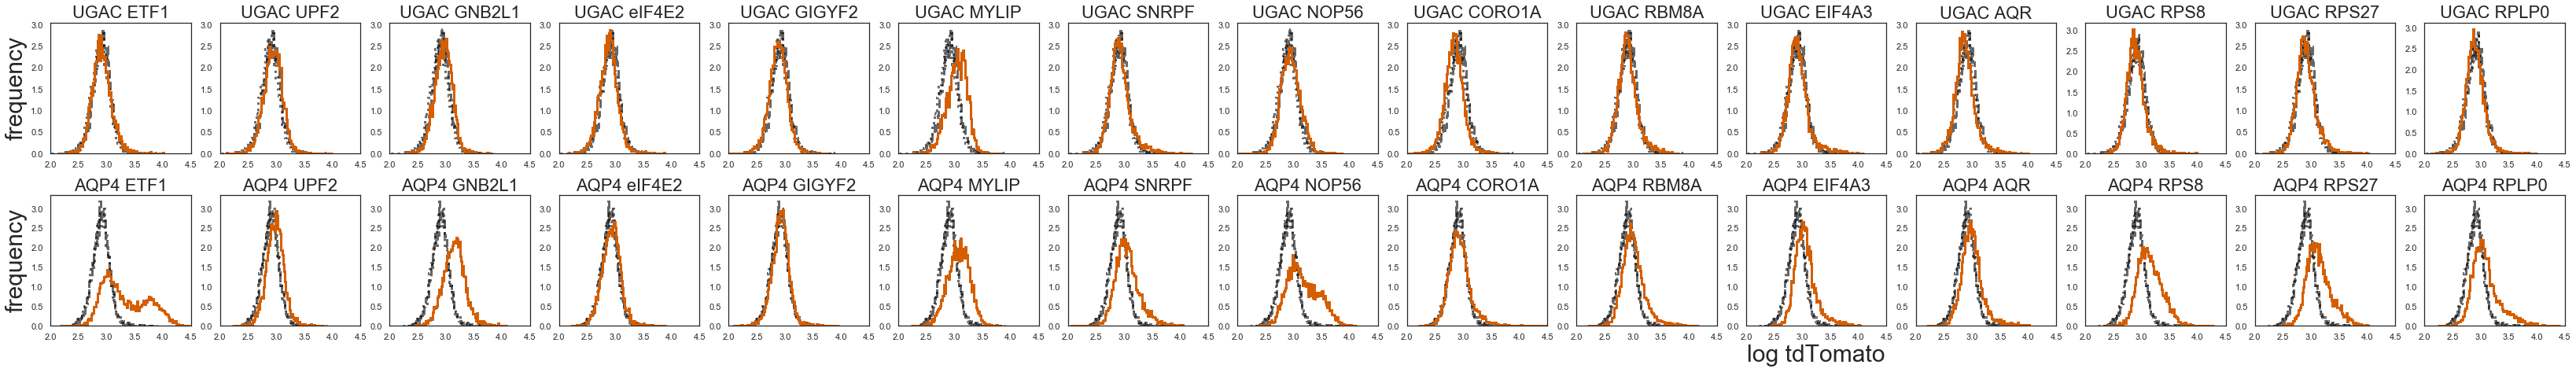

In [9]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

#xmin=0
#xmax=100
#ymin=-0.1
#ymax=4
plots=[]
num_plots_wide = 15
num_plots_high = 3

x_var='log tdTomato'
plot_index =1
fig = plt.figure(figsize=(3*num_plots_wide, 3*num_plots_high))
for stop_codon in stop_codons:
    for gene in genes[2:]:
        plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
        plots.append(plot)
        nt1_data = grouped_data.get_group((stop_codon, 'NT1', 'DMSO'))
        nt2_data = grouped_data.get_group((stop_codon, 'NT2', 'DMSO'))
        nt1_data[x_var].plot.hist(color=black, histtype='step', bins=100, normed=True, linestyle='--', alpha=0.6, ax=plot, lw=3)
        nt2_data[x_var].plot.hist(color=black, histtype='step', bins=100, normed=True, linestyle=':', alpha=0.6, ax=plot, lw=3)
        guide_data = grouped_data.get_group((stop_codon, gene, 'DMSO'))
        guide_data[x_var].plot.hist(histtype='step', bins=100, normed=True, color=vermillion, alpha=1, ax=plot, lw=3)
        plot.set_title('%s %s'% (stop_codon, gene), fontsize=22)
        plot.set_xlabel('', fontsize=1)
        plot.set_ylabel('', fontsize=1)
        #plot.set_ylabel(y_var)
        #lot.set_xlim(xmin, xmax)
        if stop_codon == 'UGAC':
            plot.set_xlim(2, 4.5)
        elif stop_codon == 'AQP4':
            plot.set_xlim(2, 4.5)
        elif stop_codon == 'UGGC':
            plot.set_xlim(2, 3.5)
        guide_index+=1
        plot_index += 1
plt.tight_layout()
plots[22].set_xlabel(x_var, fontsize=30)
plots[0].set_ylabel('frequency', fontsize=30)
plots[15].set_ylabel('frequency', fontsize=30)

plt.savefig('20190608_log_tdTomato_hist_DMSO.pdf', transparent=True)

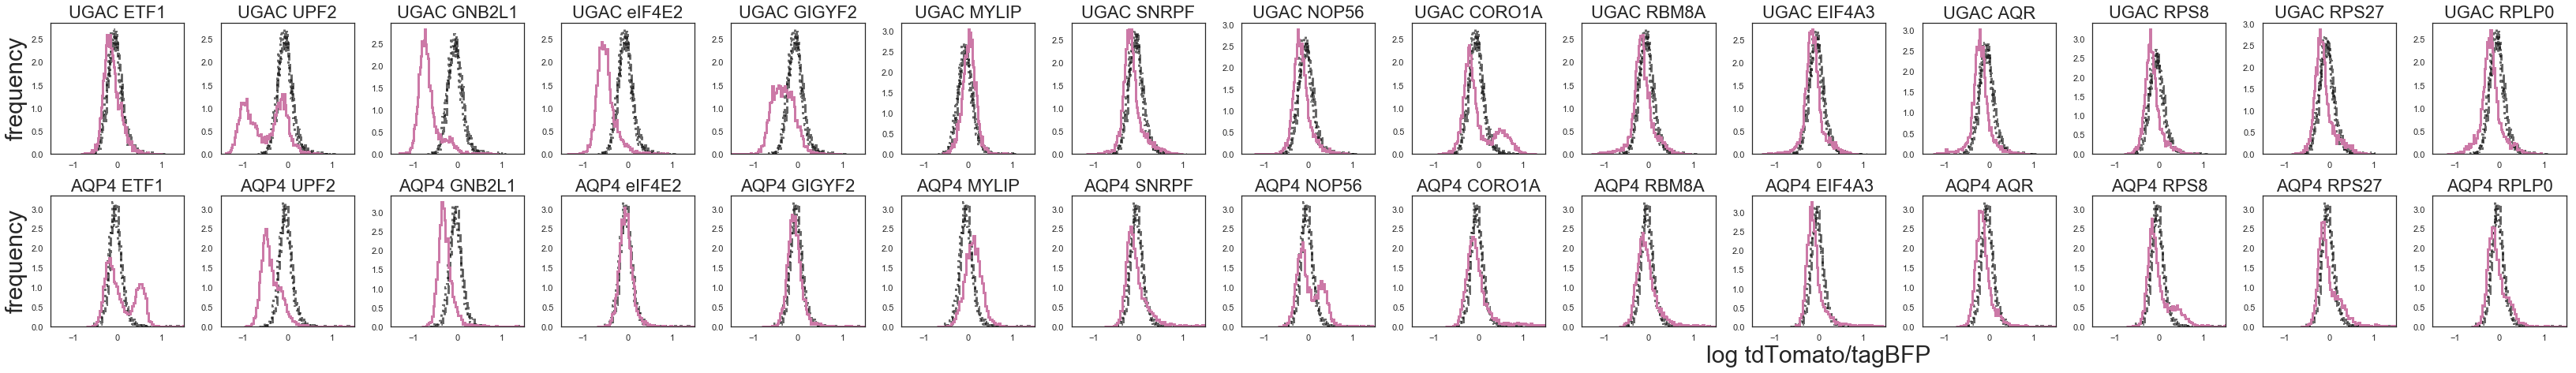

In [10]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

#xmin=0
#xmax=100
#ymin=-0.1
#ymax=4
plots=[]
num_plots_wide = 15
num_plots_high = 3

x_var='log tdTomato/tagBFP'
plot_index =1
fig = plt.figure(figsize=(3*num_plots_wide, 3*num_plots_high))
for stop_codon in stop_codons:
    for gene in genes[2:]:
        plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
        plots.append(plot)
        nt1_data = grouped_data.get_group((stop_codon, 'NT1', 'DMSO')).replace([np.inf, -np.inf], np.nan).dropna()
        nt2_data = grouped_data.get_group((stop_codon, 'NT2', 'DMSO')).replace([np.inf, -np.inf], np.nan).dropna()
        nt1_data[x_var].plot.hist(color=black, histtype='step', bins=100, normed=True, linestyle='--', alpha=0.6, ax=plot, lw=3)
        nt2_data[x_var].plot.hist(color=black, histtype='step', bins=100, normed=True, linestyle=':', alpha=0.6, ax=plot, lw=3)
        guide_data = grouped_data.get_group((stop_codon, gene, 'DMSO')).replace([np.inf, -np.inf], np.nan).dropna()
        guide_data[x_var].plot.hist(histtype='step', bins=100, normed=True, color=reddishPurple, alpha=1, ax=plot, lw=3)
        plot.set_title('%s %s'% (stop_codon, gene), fontsize=22)
        plot.set_xlabel('', fontsize=1)
        plot.set_ylabel('', fontsize=1)
        #plot.set_ylabel(y_var)
        #lot.set_xlim(xmin, xmax)
        if stop_codon == 'UGAC':
            plot.set_xlim(-1.5, 1.5)
        elif stop_codon == 'AQP4':
            plot.set_xlim(-1.5, 1.5)
        elif stop_codon == 'UGGC':
            plot.set_xlim(-1.5, 1.5)
        guide_index+=1
        plot_index += 1
plt.tight_layout()
plots[25].set_xlabel(x_var, fontsize=30)
plots[0].set_ylabel('frequency', fontsize=30)
plots[15].set_ylabel('frequency', fontsize=30)

plt.savefig('20190608_log_ratio_hist_DMSO.pdf', transparent=True)

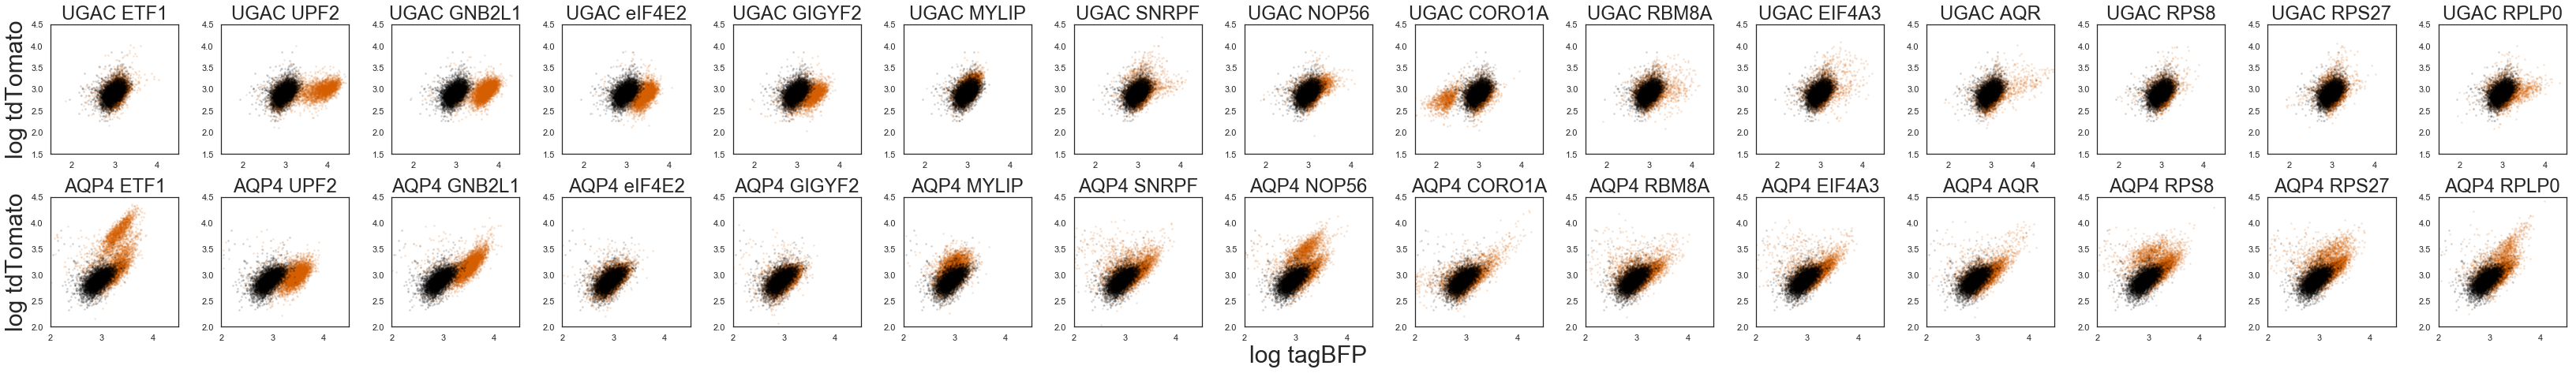

In [11]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

#xmin=0
#xmax=100
#ymin=-0.1
#ymax=4
plots=[]
num_plots_wide = 15
num_plots_high = 3

x_var='log tagBFP'
y_var='log tdTomato'
plot_index =1
fig = plt.figure(figsize=(3*num_plots_wide, 3*num_plots_high))
for stop_codon in stop_codons:
    for gene in genes[2:]:
            plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
            plots.append(plot)
            nt1_data = grouped_data.get_group((stop_codon, 'NT1', 'DMSO'))
            guide_data = grouped_data.get_group((stop_codon, gene, 'DMSO'))
            guide_data.plot.scatter(x=x_var,y=y_var, color=vermillion, alpha=0.2, ax=plot, lw=0, s=6)
            nt1_data.plot.scatter(x=x_var, y=y_var, color=black, alpha=0.2, ax=plot, lw=0, s=6)
            plot_index += 1
            plot.set_title('%s %s'% (stop_codon, gene), fontsize=24)
            plot.set_xlabel(x_var)
            plot.set_ylabel(y_var)
            if stop_codon == 'UGAC':
                plot.set_xlim(1.5, 4.5)
                plot.set_ylim(1.5, 4.5)
            elif stop_codon == 'AQP4':
                plot.set_xlim(2, 4.5)
                plot.set_ylim(2, 4.5)
            elif stop_codon == 'UGGC':
                plot.set_xlim(2, 3.5)
                plot.set_ylim(2, 3.5)
            plot.set_xlabel('', fontsize=1)
            plot.set_ylabel('', fontsize=1)
plt.tight_layout()
plots[22].set_xlabel(x_var, fontsize=30)
plots[0].set_ylabel(y_var, fontsize=30)
plots[15].set_ylabel(y_var, fontsize=30)

plt.savefig('20190608_scatter_DMSO.pdf', transparent=True)
plt.savefig('20190608_scatter_DMSO.png', transparent=True)

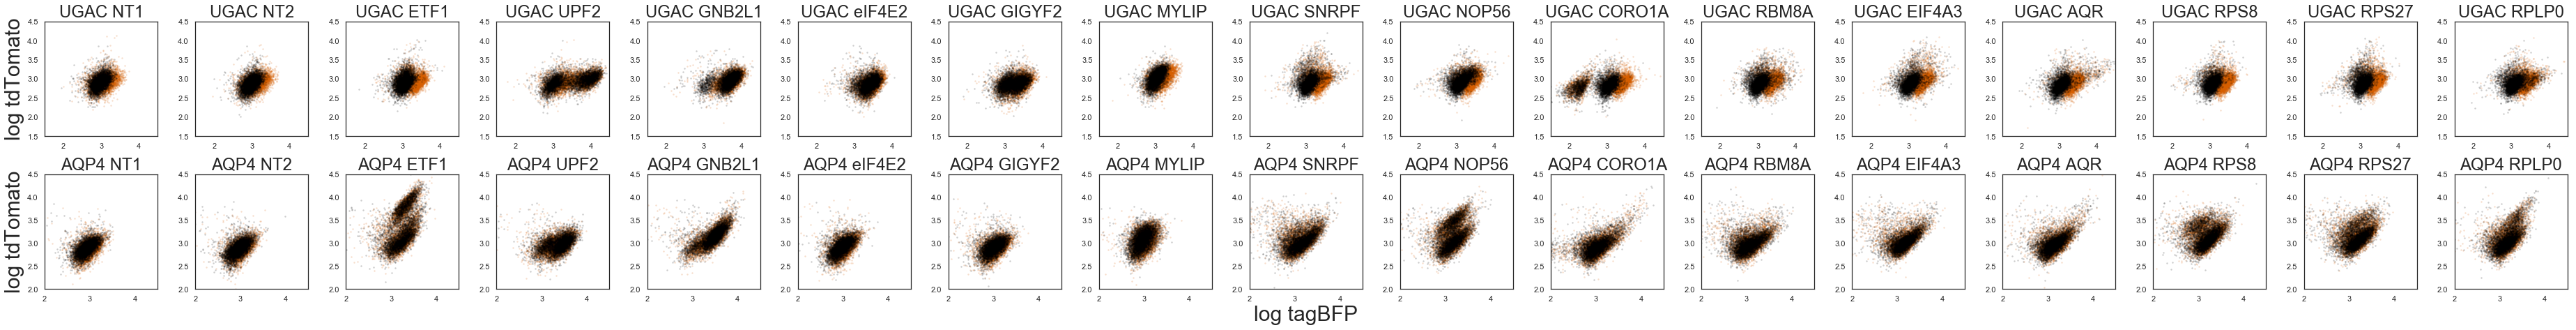

In [12]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

#xmin=0
#xmax=100
#ymin=-0.1
#ymax=4
plots=[]
num_plots_wide = 17
num_plots_high = 3

x_var='log tagBFP'
y_var='log tdTomato'
plot_index =1
fig = plt.figure(figsize=(3*num_plots_wide, 3*num_plots_high))
for stop_codon in stop_codons:
    for gene in genes:
            plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
            plots.append(plot)
            DMSO_data = grouped_data.get_group((stop_codon, gene, 'DMSO'))
            smg1i_data = grouped_data.get_group((stop_codon, gene, 'SMG1i'))
            smg1i_data.plot.scatter(x=x_var,y=y_var, color=vermillion, alpha=0.2, ax=plot, lw=0, s=6)
            DMSO_data.plot.scatter(x=x_var, y=y_var, color=black, alpha=0.2, ax=plot, lw=0, s=6)
            plot_index += 1
            plot.set_title('%s %s'% (stop_codon, gene), fontsize=24)
            plot.set_xlabel(x_var)
            plot.set_ylabel(y_var)
            if stop_codon == 'UGAC':
                plot.set_xlim(1.5, 4.5)
                plot.set_ylim(1.5, 4.5)
            elif stop_codon == 'AQP4':
                plot.set_xlim(2, 4.5)
                plot.set_ylim(2, 4.5)
            elif stop_codon == 'UGGC':
                plot.set_xlim(2, 3.5)
                plot.set_ylim(2, 3.5)
            plot.set_xlabel('', fontsize=1)
            plot.set_ylabel('', fontsize=1)
plt.tight_layout()
plots[25].set_xlabel(x_var, fontsize=30)
plots[0].set_ylabel(y_var, fontsize=30)
plots[17].set_ylabel(y_var, fontsize=30)

plt.savefig('20190608_scatter_smg1i_vs_dmso.pdf', transparent=True)
plt.savefig('20190608_scatter_smg1i_vs_dmso.png', transparent=True)

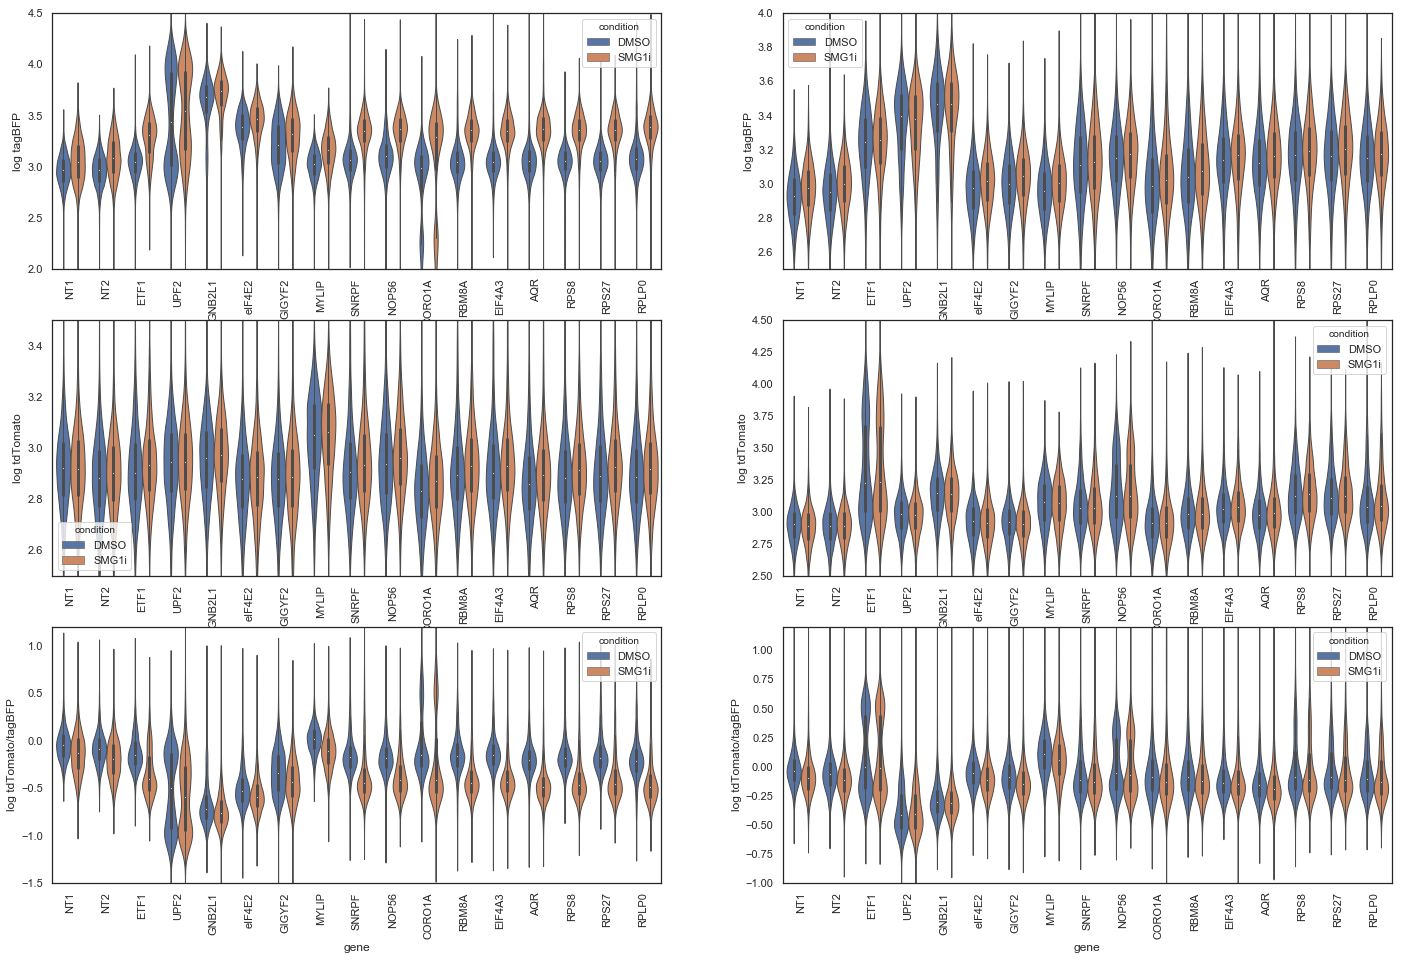

In [18]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)

#grouped_data = all_data.groupby(['stop codon', 'gene'])
fig, ax = plt.subplots(3,2, figsize=(24, 16), sharey=False)
sample_data=all_data
sns.violinplot(x="gene", y="log tagBFP", scale='width', hue='condition', data=sample_data[sample_data['stop codon']=='UGAC'], ax=ax[0][0], linewidth=1)
sns.violinplot(x="gene", y="log tdTomato", scale='width', hue='condition', data=sample_data[sample_data['stop codon']=='UGAC'], ax=ax[1][0], linewidth=1)
sns.violinplot(x="gene", y="log tdTomato/tagBFP", scale='width', hue='condition', data=sample_data[sample_data['stop codon']=='UGAC'], ax=ax[2][0], linewidth=1)
sns.violinplot(x="gene", y="log tagBFP", scale='width', hue='condition', data=sample_data[sample_data['stop codon']=='AQP4'], ax=ax[0][1], linewidth=1)
sns.violinplot(x="gene", y="log tdTomato", scale='width', hue='condition', data=sample_data[sample_data['stop codon']=='AQP4'], ax=ax[1][1], linewidth=1)
sns.violinplot(x="gene", y="log tdTomato/tagBFP", scale='width', hue='condition', data=sample_data[sample_data['stop codon']=='AQP4'].replace([np.inf, -np.inf], np.nan).dropna(), ax=ax[2][1], linewidth=1)

ax[0][0].set_ylim(2,4.5)
ax[0][1].set_ylim(2.5,4)
ax[1][0].set_ylim(2.5,3.5)
ax[1][1].set_ylim(2.5,4.5)
ax[2][0].set_ylim(-1.5,1.2)
ax[2][1].set_ylim(-1.,1.2)
for axis1 in ax:
    for axis in axis1:
        for label in axis.get_xticklabels():
            label.set_rotation(90)
plt.savefig('20190608_violin.pdf', transparent=True)